In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install plotly ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=c46f1ac6af73cc8038dd3e8610860dba7a7171badf2c5b59d37393a322326e75
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import joblib
from datetime import datetime, timedelta

In [4]:
# Recopilación de Datos
sp500_ticker = "MES=F"
start_date = "2020-05-25"
end_date = "2024-07-01"

sp500_data = yf.download(sp500_ticker, start=start_date, end=end_date)
sp500_close_volume = sp500_data[["Open", "High", "Low", 'Close', 'Volume']]
vix_data = yf.download("^VIX", start=start_date, end=end_date)

# Ingeniería de Características
sp500_close_volume['EMA_10'] = ta.trend.EMAIndicator(sp500_close_volume['Close'], window=10).ema_indicator()
sp500_close_volume['EMA_5'] = ta.trend.EMAIndicator(sp500_close_volume['Close'], window=5).ema_indicator()

""""
# Establecer un valor específico para 'Close' y 'Volume' en las dos última fecha
last_index = sp500_close_volume.index[-2]  # Obtiene el último índice
sp500_close_volume.at[last_index, 'Open'] = 5299.25
sp500_close_volume.at[last_index, 'High'] = 5315.00
sp500_close_volume.at[last_index, 'Low'] = 5246.75
sp500_close_volume.at[last_index, 'Close'] = 5297.25
sp500_close_volume.at[last_index, 'Volume'] = 1078000

last_index = sp500_close_volume.index[-1]  # Obtiene el último índice
sp500_close_volume.at[last_index, 'Open'] = 5300.00
sp500_close_volume.at[last_index, 'High'] = 5312.25
sp500_close_volume.at[last_index, 'Low'] = 5262.00
sp500_close_volume.at[last_index, 'Close'] = 5304.00
sp500_close_volume.at[last_index, 'Volume'] = 1003000

# Ingeniería de Características
#sp500_close_volume['EMA_20'] = ta.trend.EMAIndicator(sp500_close_volume['Close'], window=20).ema_indicator()
sp500_close_volume['SMA_10'] = ta.trend.SMAIndicator(sp500_close_volume['Close'], window=10).sma_indicator()
sp500_close_volume['SMA_5'] = ta.trend.SMAIndicator(sp500_close_volume['Close'], window=5).sma_indicator()
sp500_close_volume['RSI_14'] = ta.momentum.RSIIndicator(sp500_close_volume['Close'], window=14).rsi()
sp500_close_volume['CCI'] = ta.trend.CCIIndicator(sp500_close_volume['High'], sp500_close_volume['Low'], sp500_close_volume['Close'], window=14).cci()
sp500_close_volume['ATR'] = ta.volatility.AverageTrueRange(sp500_close_volume['High'], sp500_close_volume['Low'], sp500_close_volume['Close'], window=14).average_true_range()
sp500_close_volume['VIX'] = vix_data[['Close']]
"""
# Guardar el DataFrame sp500_close_volume como CSV en la ruta especificada
csv_path_sp500 = '/content/drive/My Drive/UTN/2024/202401/1_Investigacion/2024/IA_FIN_5_ANOS/Fuentes/Articulos/3/20240701_entrada_v83.csv'
sp500_close_volume.to_csv(csv_path_sp500, index=True)

sp500_close_volume

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Open     High      Low   Close   Volume       EMA_10  \
Date                                                                  
2020-05-26  2948.75  3019.75  2947.75  2994.5  1023998          NaN   
2020-05-27  2994.25  3039.75  2965.50  3035.5  1168154          NaN   
2020-05-28  3034.50  3065.50  3019.50  3038.0   958717          NaN   
2020-05-29  3036.00  3058.50  2992.25  3042.0  1176313          NaN   
2020-06-01  3032.00  3058.75  3007.75  3054.0   714753          NaN   
...             ...      ...      ...     ...      ...          ...   
2024-06-24  5538.25  5558.50  5510.25  5517.0   830166  5451.052606   
2024-06-25  5515.75  5539.75  5511.00  5537.0   688858  5466.679405   
2024-06-26  5535.00  5552.00  5516.25  5543.5   689929  5480.646786   
2024-06-27  5533.25  5555.00  5516.00  5546.0   779042  5492.529188   
2024-06-28  5548.75  5585.00  5510.50  5521.5   779042  5497.796609   

                  EMA_5  
Date                     
2020-05-26          NaN  
2020-05-27          NaN  
2020-05-28          NaN  
2020-05-29          NaN  
2020-06-01  3035.382716  
...                 ...  
2024-06-24  5482.341744  
2024-06-25  5500.561163  
2024-06-26  5514.874108  
2024-06-27  5525.249406  
2024-06-28  5523.999604  

[1032 rows x 7 columns]

In [11]:
# Eliminar NaNs
sp500_clean = sp500_close_volume.dropna()

# Escalar los datos antes de aplicar PCA
scaler = MinMaxScaler()
sp500_scaled = scaler.fit_transform(sp500_clean)

# Análisis de Componentes Principales (PCA)
c = 5 #Componentes
pca = PCA(n_components=c)
pca_result = pca.fit_transform(sp500_scaled)
pca_df = pd.DataFrame(data=pca_result, columns=[f'Principal Component {i+1}' for i in range(c)], index=sp500_clean.index)

# Calcular la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Crear un DataFrame resumen
explained_variance_df = pd.DataFrame({
    'Component': [f'Principal Component {i+1}' for i in range(c)],
    'Explained Variance Ratio': explained_variance,
    'Cumulative Variance': explained_variance.cumsum()
})

# Mostrar el DataFrame resumen
print(explained_variance_df)

               Component  Explained Variance Ratio  Cumulative Variance
0  Principal Component 1                  0.905713             0.905713
1  Principal Component 2                  0.092453             0.998166
2  Principal Component 3                  0.001111             0.999277
3  Principal Component 4                  0.000445             0.999722
4  Principal Component 5                  0.000186             0.999908


In [12]:
# División Temporal de Datos
train_size = int(len(pca_df) * 0.6)
val_size = int(len(pca_df) * 0.2)
test_size = len(pca_df) - train_size - val_size

X_train = pca_df.iloc[:train_size]
y_train = sp500_clean['Close'].iloc[:train_size]
X_val = pca_df.iloc[train_size:train_size + val_size]
y_val = sp500_clean['Close'].iloc[train_size:train_size + val_size]
X_test = pca_df.iloc[train_size + val_size:]
y_test = sp500_clean['Close'].iloc[train_size + val_size:]

# Escalador para la variable objetivo
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [13]:
# Crear secuencias para LSTM
def create_sequences(data, target, window_size=1):
    xs = []
    ys = []
    for i in range(len(data) - window_size):
        x = data[i:(i + window_size)]
        y = target[i + window_size]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

window_size = 1
X_train_seq, y_train_seq = create_sequences(X_train.values, y_train_scaled.flatten(), window_size)
X_val_seq, y_val_seq = create_sequences(X_val.values, y_val_scaled.flatten(), window_size)
X_test_seq, y_test_seq = create_sequences(X_test.values, y_test_scaled.flatten(), window_size)

# Definir el modelo LSTM
def build_model(input_shape):
    model = Sequential([
        LSTM(50, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Configurar el callback de Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=30, verbose=1, mode='min', restore_best_weights=True)

Restoring model weights from the end of the best epoch: 7.
Epoch 37: early stopping


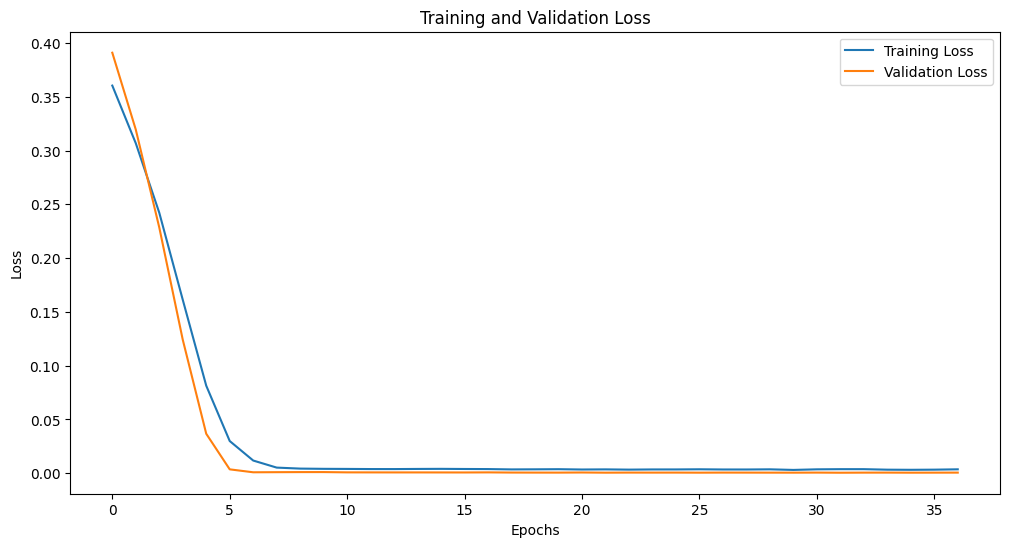

In [14]:
# Entrenar modelo con los datos de entrenamiento y validación
model = build_model((window_size, X_train_seq.shape[2]))
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=50, verbose=0, validation_data=(X_val_seq, y_val_seq),
                    callbacks=[early_stopping])

# Gráfico de pérdida para entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [15]:
# Guardar el modelo entrenado en un archivo con joblib
model_path = '/content/drive/My Drive/UTN/2024/202401/1_Investigacion/2024/IA_FIN_5_ANOS/Fuentes/Articulos/3/20240701_trained_model_v83.pkl'
joblib.dump(model, model_path)

['/content/drive/My Drive/UTN/2024/202401/1_Investigacion/2024/IA_FIN_5_ANOS/Fuentes/Articulos/3/20240701_trained_model_v83.pkl']

In [16]:
# Cargar el modelo entrenado desde el archivo
#model_path = '/content/drive/My Drive/UTN/2024/202401/1_Investigacion/2024/IA_FIN_5_ANOS/Fuentes/Articulos/3/20240529_trained_model_v8.pkl'
#model = joblib.load(model_path)

# Walk-Forward Validation solo con los datos de prueba
actuals = []
predictions = []
test_losses = []
step_size = 1

for i in range(len(X_test_seq)):
    X_test_wfv, y_test_wfv = X_test_seq[i:i+step_size], y_test_seq[i:i+step_size]

    # Hacer predicciones para el paso actual
    preds = model.predict(X_test_wfv).flatten()
    preds_rescaled = scaler_y.inverse_transform(preds.reshape(-1, 1)).flatten()
    y_test_rescaled = scaler_y.inverse_transform(y_test_wfv.reshape(-1, 1)).flatten()

    predictions.extend(preds_rescaled)
    actuals.extend(y_test_rescaled)

    # Evaluar el modelo sobre los datos de prueba actuales y almacenar la pérdida
    test_loss = mean_squared_error(y_test_rescaled, preds_rescaled)
    test_losses.append(test_loss)

    # Actualizar el modelo con nuevos datos
    h = model.fit(X_test_wfv, y_test_wfv, epochs=100, batch_size=50, verbose=0, validation_data=(X_test_wfv, y_test_wfv),
              callbacks=[early_stopping])

    print(f"Iteración N° {i}")

1/1 [==============================] - 1s 909ms/step
Restoring model weights from the end of the best epoch: 1.
Epoch 31: early stopping
Iteración N° 0
1/1 [==============================] - 0s 23ms/step
Restoring model weights from the end of the best epoch: 1.
Epoch 31: early stopping
Iteración N° 1
1/1 [==============================] - 0s 24ms/step
Restoring model weights from the end of the best epoch: 12.
Epoch 42: early stopping
Iteración N° 2
1/1 [==============================] - 0s 34ms/step
Restoring model weights from the end of the best epoch: 1.
Epoch 31: early stopping
Iteración N° 3
1/1 [==============================] - 0s 33ms/step
Restoring model weights from the end of the best epoch: 1.
Epoch 31: early stopping
Iteración N° 4
1/1 [==============================] - 0s 25ms/step
Restoring model weights from the end of the best epoch: 1.
Epoch 31: early stopping
Iteración N° 5
1/1 [==============================] - 0s 22ms/step
Restoring model weights from the end of 

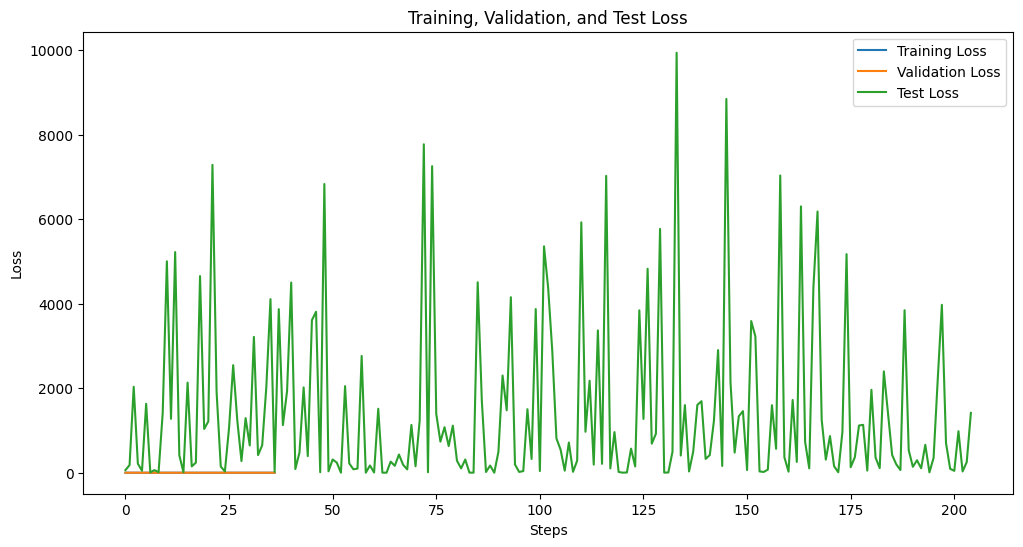

In [17]:
# Gráfico de pérdida para entrenamiento, validación y prueba
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()

In [18]:
# Eliminar el primer valor del índice
y_test_index_modified = y_test.index[1:]  # Esto elimina el primer valor del índice
results_df1 = pd.DataFrame({'Actual': actuals, 'Predicted': predictions}, y_test_index_modified)
last_date = results_df1.index[-1]
next_date = last_date + timedelta(days=1)
extended_index = y_test_index_modified.tolist() + [next_date]

In [19]:
# Predicción para el siguiente día después del último día disponible
last_sequence = X_test_seq[-window_size:].reshape(1, window_size, X_test_seq.shape[2])
next_step_prediction = model.predict(last_sequence).flatten()[0]
next_step_prediction_rescaled = scaler_y.inverse_transform(np.array([next_step_prediction]).reshape(-1, 1)).flatten()[0]
print("La predicción para el siguiente día es:", next_step_prediction_rescaled)
predictions.append(next_step_prediction_rescaled)  # Agregar predicción
actuals.append(actuals[-1])  # Repetir el último valor real para alinear con la predicción futura
results_df = pd.DataFrame({'Actual': actuals, 'Predicted': predictions}, extended_index)
results_df

1/1 [==============================] - 0s 25ms/step
La predicción para el siguiente día es: 5529.141


Actual    Predicted
2023-09-07  4456.25  4464.113281
2023-09-08  4461.75  4448.326660
2023-09-11  4490.25  4445.151367
2023-09-12  4465.00  4479.611328
2023-09-13  4468.75  4475.582520
...             ...          ...
2024-06-25  5537.00  5568.349121
2024-06-26  5543.50  5538.013184
2024-06-27  5546.00  5561.868652
2024-06-28  5521.50  5559.137207
2024-06-29  5521.50  5529.141113

[206 rows x 2 columns]

In [20]:
# Visualizar los resultados
fig = go.Figure()

fig.add_trace(go.Scatter(x=results_df.index, y=results_df['Actual'], mode='lines', name='Actual', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=results_df.index, y=results_df['Predicted'], mode='lines', name='Predicted', line=dict(dash='dash', color='red')))

# Calcular métricas para WFV
wfv_mae = mean_absolute_error(results_df['Actual'].dropna(), results_df['Predicted'].dropna())
wfv_mse = mean_squared_error(results_df['Actual'].dropna(), results_df['Predicted'].dropna())
wfv_rmse = np.sqrt(wfv_mse)
wfv_errors = np.abs(results_df['Actual'].dropna() - results_df['Predicted'].dropna())
wfv_std_dev_ae = np.std(wfv_errors)
wfv_mape = np.mean(np.abs((results_df['Actual'].dropna() - results_df['Predicted'].dropna()) / results_df['Actual'].dropna())) * 100

fig.update_layout(
    title=f'Actual vs Predicted Prices (WFV)<br>Prediction for the next day: {next_step_prediction_rescaled:.2f}<br>RMSE: {wfv_rmse:.6f}<br>MAE: {wfv_mae:.6f}<br>SD of AE: {wfv_std_dev_ae:.6f}<br>MAPE: {wfv_mape:.6f}%',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend'
)

print(f'MES: {wfv_mse:.2f}<br>RMSE: {wfv_rmse:.6f}<br>MAE: {wfv_mae:.6f}<br>SD of AE: {wfv_std_dev_ae:.6f}<br>MAPE: {wfv_mape:.6f}%')
fig.show()

MES: 1432.74<br>RMSE: 37.851517<br>MAE: 29.695519<br>SD of AE: 23.471547<br>MAPE: 0.613114%


In [21]:
# Crear una nueva columna 'DifferenceA' donde cada valor es 'Actual' - 'Actual anterior' de la fila anterior.
#results_df['DifferenceA'] = results_df['Actual'] - results_df['Actual'].shift(1)

# Crear una nueva columna 'DifferenceP' donde cada valor es 'Predicted' - 'Predicted anterior' de la fila anterior.
results_df['DifferenceP'] = results_df['Predicted']- results_df['Predicted'].shift(1)

# Crear la columna 'c1v-1' usando np.where
results_df['c1v-1'] = np.where(results_df['DifferenceP'] >= 0, 1, -1)


# Calculamos las diferencias entre el valor actual y el valor anterior de 'Actual'
results_df['Prev_Actual'] = results_df['Actual'].shift(1)
results_df['DifferenceA'] = results_df['Actual'] - results_df['Prev_Actual']

# Crear la columna 'Actual_SB' usando np.where
results_df['Actual_SB'] = np.where(results_df['DifferenceA'] >= 0, 1, -1)

# Definimos una función que evalúa las condiciones y calcula el valor de 'gan'
def calculate_gain(row):
    if row['c1v-1'] == 1:
        return row['DifferenceA']  # Si c1v-1 es 0, retorna la diferencia directamente.
    else:
        if row['Actual'] < row['Prev_Actual']:
            return -row['DifferenceA']  # Si c1v-1 es -1 y Actual es menor, retorno positivo de la diferencia.
        else:
            return -row['DifferenceA']  # Si c1v-1 es -1 y Actual es mayor, retorno negativo de la diferencia.

# Aplicamos la función para crear la columna 'G/P_P'
results_df['G/P_P'] = results_df.apply(calculate_gain, axis=1)

# Aplicamos la función para crear la columna 'G/P_D'
results_df['G/P_D'] = results_df['G/P_P'] * 5

# Eliminamos la columna auxiliar si no es necesaria
results_df.drop('Prev_Actual', axis=1, inplace=True)

# Crear la columna 'decision' basada en las condiciones especificadas
results_df['decision'] = np.where(
    ((results_df['c1v-1'] == 1) & (results_df['G/P_P'] >= 0)) |
    ((results_df['c1v-1'] == -1) & (results_df['G/P_P'] >= 0)),
    'Correcta',
    'Incorrecta'
)

# Mostrar las primeras filas del DataFrame para verificar los resultados
#print(results_df.head(5))

# Mostrar las ultimas filas del DataFrame para verificar los resultados
#print(results_df.tail(5))

# Calcular la suma total de la columna 'gan'
total_gain_P = results_df['G/P_P'].sum()
total_gain_D = results_df['G/P_D'].sum()

# Imprimir el resultado
print("La suma total de la columna 'G/P_P' es:", total_gain_P)
print("La suma total de la columna 'G/P_D' es:", total_gain_D)

results_df

La suma total de la columna 'G/P_P' es: 622.2900390625
La suma total de la columna 'G/P_D' es: 3111.4501953125


Actual    Predicted  DifferenceP  c1v-1  DifferenceA  Actual_SB  \
2023-09-07  4456.25  4464.113281          NaN     -1          NaN         -1   
2023-09-08  4461.75  4448.326660   -15.786621     -1         5.50          1   
2023-09-11  4490.25  4445.151367    -3.175293     -1        28.50          1   
2023-09-12  4465.00  4479.611328    34.459961      1       -25.25         -1   
2023-09-13  4468.75  4475.582520    -4.028809     -1         3.75          1   
...             ...          ...          ...    ...          ...        ...   
2024-06-25  5537.00  5568.349121    44.667969      1        20.00          1   
2024-06-26  5543.50  5538.013184   -30.335938     -1         6.50          1   
2024-06-27  5546.00  5561.868652    23.855469      1         2.50          1   
2024-06-28  5521.50  5559.137207    -2.731445     -1       -24.50         -1   
2024-06-29  5521.50  5529.141113   -29.996094     -1         0.00          1   

            G/P_P   G/P_D    decision  
2023-09-07    NaN     NaN  Incorrecta  
2023-09-08  -5.50  -27.50  Incorrecta  
2023-09-11 -28.50 -142.50  Incorrecta  
2023-09-12 -25.25 -126.25  Incorrecta  
2023-09-13  -3.75  -18.75  Incorrecta  
...           ...     ...         ...  
2024-06-25  20.00  100.00    Correcta  
2024-06-26  -6.50  -32.50  Incorrecta  
2024-06-27   2.50   12.50    Correcta  
2024-06-28  24.50  122.50    Correcta  
2024-06-29  -0.00   -0.00    Correcta  

[206 rows x 9 columns]

In [22]:
def calculate_sharpe_ratio(returns, initial_capital, risk_free_rate=0.05):
    returns = returns / initial_capital
    excess_returns = returns - risk_free_rate / 252
    return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)

def calculate_sortino_ratio(returns, initial_capital, risk_free_rate=0.05):
    returns = returns / initial_capital
    excess_returns = returns - risk_free_rate / 252
    negative_returns = returns[returns < 0]
    downside_deviation = np.std(negative_returns)
    return np.mean(excess_returns) / downside_deviation * np.sqrt(252)

def calculate_maximum_drawdown(returns, initial_capital):
    cumulative_returns = np.cumsum(returns) + initial_capital
    rolling_max = np.maximum.accumulate(cumulative_returns)
    drawdown = cumulative_returns / rolling_max - 1.0
    return drawdown.min()

def calculate_rate_of_return(returns, initial_capital):
    final_value = initial_capital + np.sum(returns)
    return (final_value - initial_capital) / initial_capital

def calculate_total_return(returns):
    return np.sum(returns)

In [23]:
# Supongamos que results_df es tu DataFrame que contiene la columna 'G/P_D'
# Cargar el DataFrame (asegúrate de ajustar el path a tu archivo CSV)
# results_df = pd.read_csv('path_to_your_csv_file.csv')

# Definir el capital inicial
initial_capital = 2000

# Calcular retornos diarios a partir de la columna 'G/P_D'
returns = results_df['G/P_D'].dropna().values

# Calcular Sharpe Ratio
sharpe_ratio = calculate_sharpe_ratio(returns, initial_capital)
print(f'Sharpe Ratio: {sharpe_ratio}')

# Calcular Sortino Ratio
sortino_ratio = calculate_sortino_ratio(returns, initial_capital)
print(f'Sortino Ratio: {sortino_ratio}')

# Calcular Maximum Drawdown
max_drawdown = calculate_maximum_drawdown(returns, initial_capital)
print(f'Maximum Drawdown: {max_drawdown}')

# Calcular Rate of Return
rate_of_return = calculate_rate_of_return(returns, initial_capital)
print(f'Rate of Return: {rate_of_return}')

# Calcular Total Return
total_return = calculate_total_return(returns)
print(f'Total Return: {total_return}')

Sharpe Ratio: 1.3184045198877345
Sortino Ratio: 1.9940459105621076
Maximum Drawdown: -0.3329579520040604
Rate of Return: 1.55572509765625
Total Return: 3111.4501953125


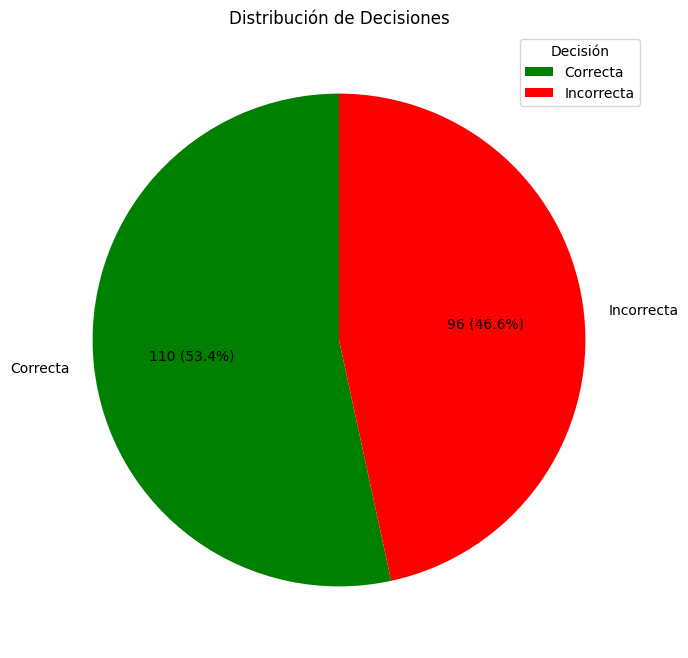

In [24]:
#Cantidad de decisiones correctas

# Recuento de entradas por categoría en la columna 'decision'
decision_counts = results_df['decision'].value_counts()

# Función para formatear las etiquetas con valores absolutos y porcentajes
def absolute_and_percent(val):
    a = int(np.round(val/100.*decision_counts.sum()))
    return f"{a} ({val:.1f}%)"

# Graficar el gráfico de pastel
plt.figure(figsize=(8, 8))  # Ajustar tamaño del gráfico
plt.pie(decision_counts, labels=decision_counts.index, autopct=absolute_and_percent, startangle=90, colors=['green', 'red'])
plt.title('Distribución de Decisiones')

# Opcional: agregar una leyenda
plt.legend(decision_counts.index, title="Decisión", loc="best")

plt.show()


In [25]:
# Agrupar por 'c1v-1' y contar las decisiones en cada grupo
grouped_decision_counts = results_df.groupby('decision')['c1v-1'].value_counts().unstack()

print(grouped_decision_counts)  # Ver los datos agrupados

c1v-1       -1   1
decision          
Correcta    42  68
Incorrecta  50  46


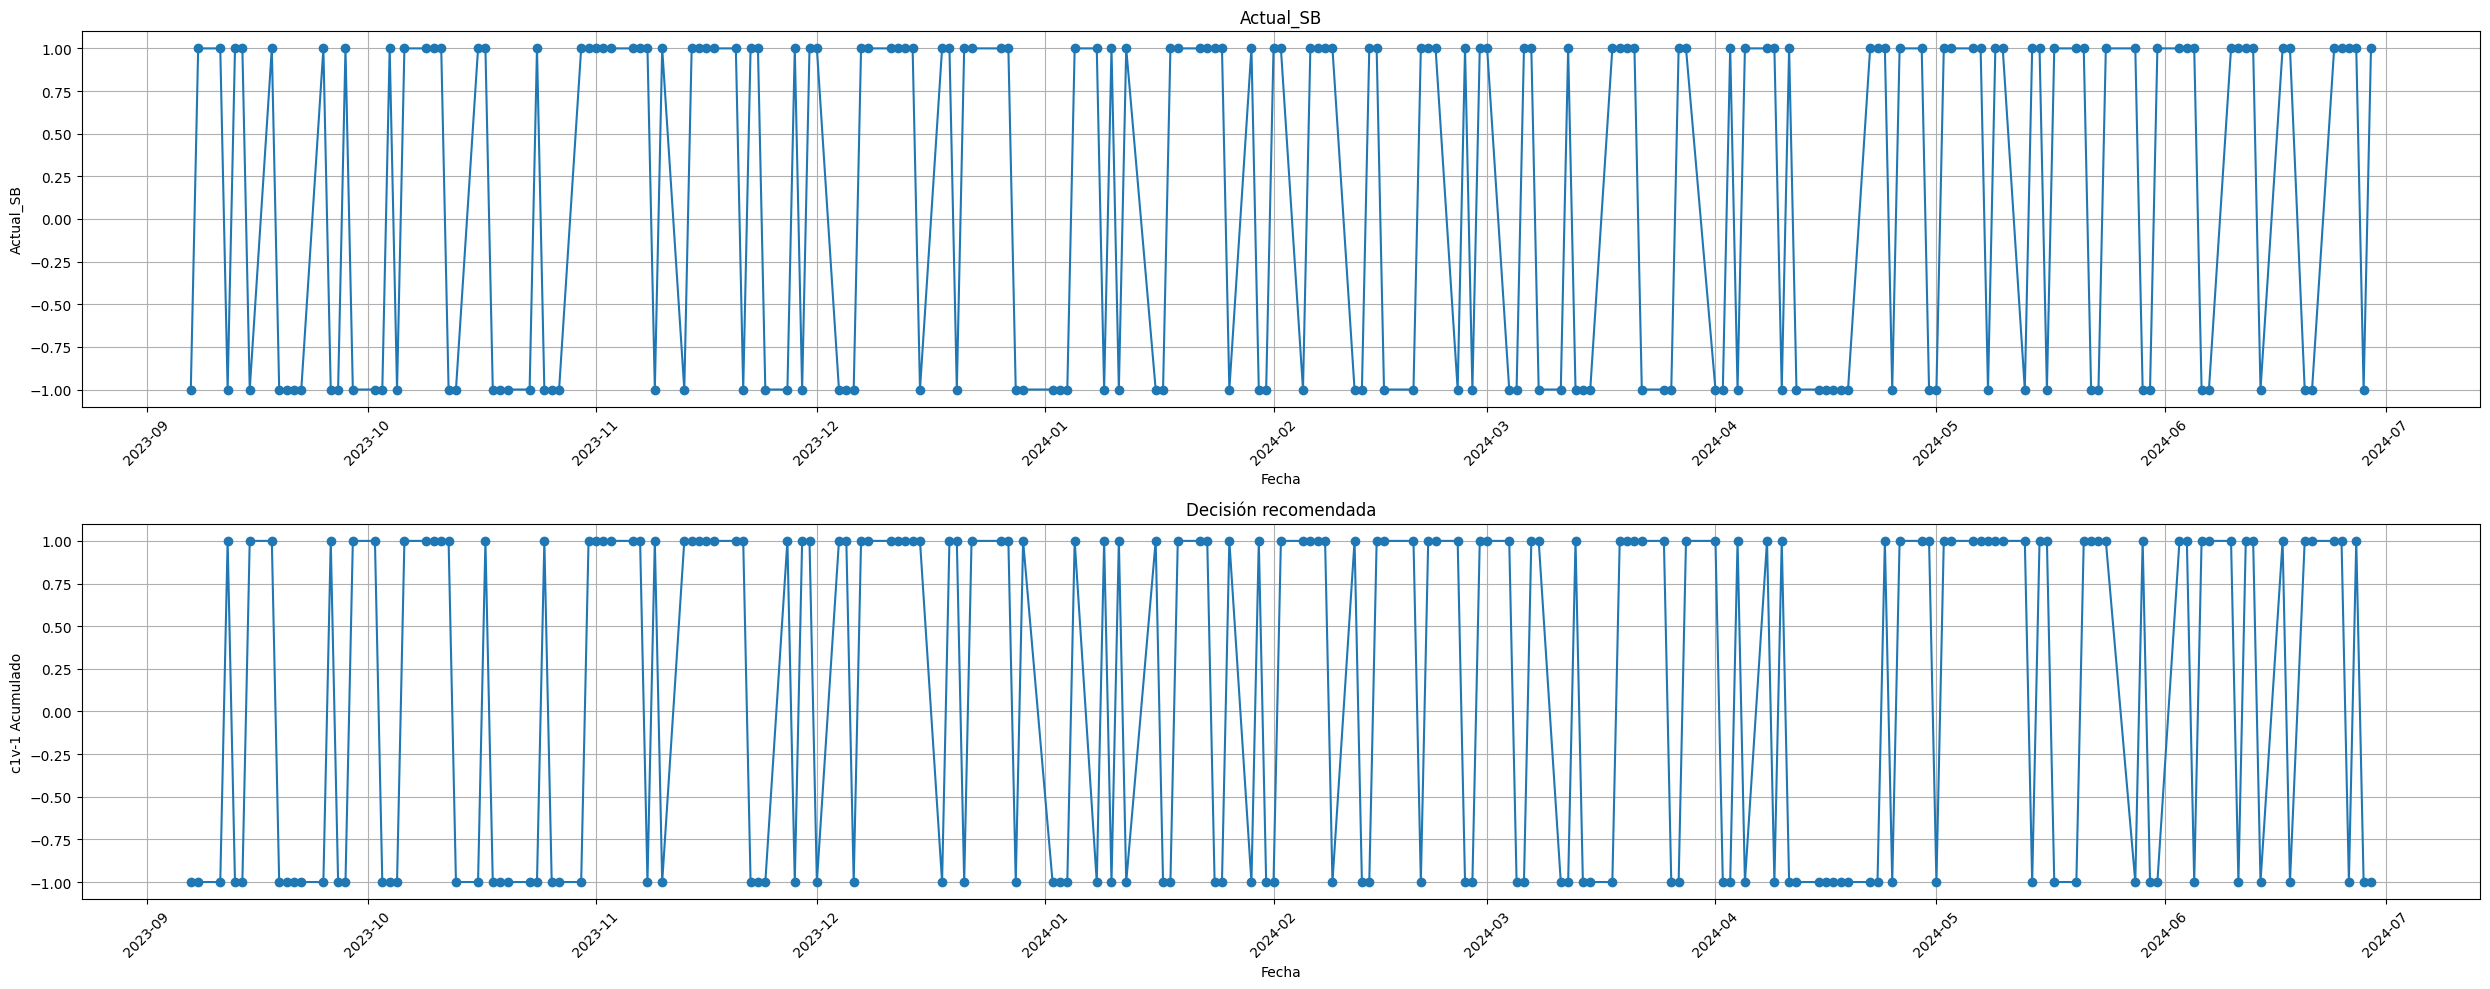

In [26]:
# Crear una figura con tres subplots (3 filas, 1 columna)
fig, axes = plt.subplots(2, 1, figsize=(25, 10))

# Graficar el acumulado de 'Actual_SB' por fecha
axes[0].plot(results_df.index, results_df['Actual_SB'], marker='o', linestyle='-')
axes[0].set_title('Actual_SB')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Actual_SB')
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)

# Graficar el acumulado de 'c1v-1' por fecha
axes[1].plot(results_df.index, results_df['c1v-1'], marker='o', linestyle='-')
axes[1].set_title('Decisión recomendada')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('c1v-1 Acumulado')
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)

# Ajustar automáticamente los parámetros de la subtrama para dar espacio al diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

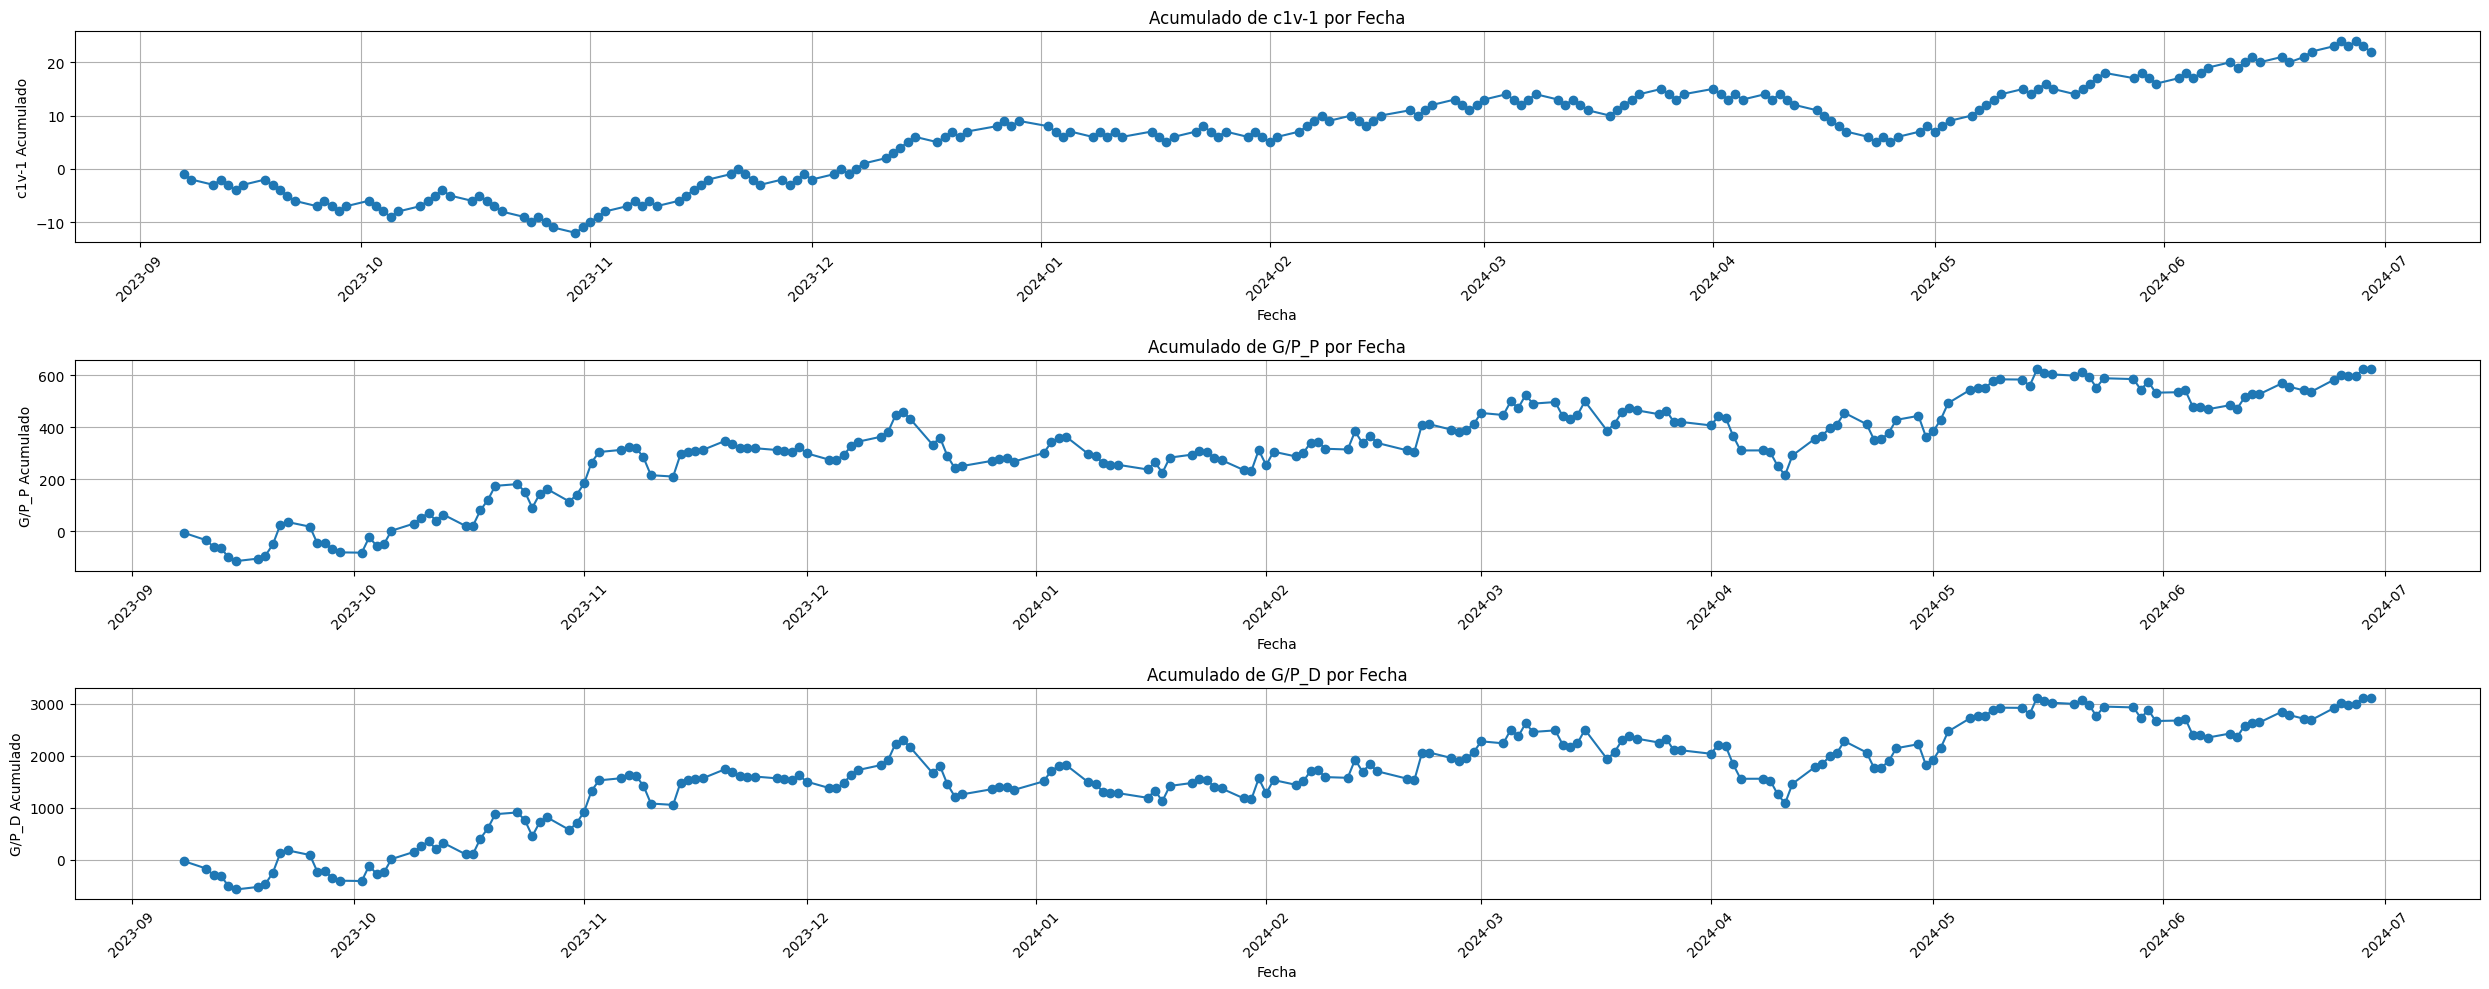

In [27]:
# Calcular la suma acumulativa
results_df['c1v-1_acumulado'] = results_df['c1v-1'].cumsum()
results_df['G/P_P_acumulado'] = results_df['G/P_P'].cumsum()
results_df['G/P_D_acumulado'] = results_df['G/P_D'].cumsum()

# Crear una figura con tres subplots (3 filas, 1 columna)
fig, axes = plt.subplots(3, 1, figsize=(25, 10))

# Graficar el acumulado de 'G/P_P' por fecha
axes[0].plot(results_df.index, results_df['c1v-1_acumulado'], marker='o', linestyle='-')
axes[0].set_title('Acumulado de c1v-1 por Fecha')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('c1v-1 Acumulado')
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)

# Graficar el acumulado de 'G/P_P' por fecha
axes[1].plot(results_df.index, results_df['G/P_P_acumulado'], marker='o', linestyle='-')
axes[1].set_title('Acumulado de G/P_P por Fecha')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('G/P_P Acumulado')
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)

# Graficar el acumulado de 'G/P_D' por fecha
axes[2].plot(results_df.index, results_df['G/P_D_acumulado'], marker='o', linestyle='-')
axes[2].set_title('Acumulado de G/P_D por Fecha')
axes[2].set_xlabel('Fecha')
axes[2].set_ylabel('G/P_D Acumulado')
axes[2].grid(True)
axes[2].tick_params(axis='x', rotation=45)

# Ajustar automáticamente los parámetros de la subtrama para dar espacio al diseño
plt.tight_layout()

# Mostrar la figura
plt.show()


In [28]:
results_df.describe ()

Actual    Predicted  DifferenceP       c1v-1  DifferenceA  \
count   206.000000   206.000000   205.000000  206.000000   205.000000   
mean   4885.889807  4882.612793     5.195258    0.106796     5.196341   
std     383.306560   383.021576    36.184837    0.996703    35.430437   
min    4137.750000  4123.534180  -117.447266   -1.000000   -80.500000   
25%    4533.437500  4547.689697   -13.775391   -1.000000   -13.250000   
50%    4958.250000  4950.469971     3.596191    1.000000     3.750000   
75%    5214.500000  5218.583130    24.346680    1.000000    27.000000   
max    5546.000000  5568.349121   118.736328    1.000000   113.080078   

        Actual_SB       G/P_P       G/P_D  c1v-1_acumulado  G/P_P_acumulado  \
count  206.000000  205.000000  205.000000       206.000000       205.000000   
mean     0.145631    3.035561   15.177806         6.179612       326.374759   
std      0.991749   35.681793  178.408966         9.062481       183.641974   
min     -1.000000 -113.080078 -565.400391       -12.000000      -114.529785   
25%     -1.000000  -16.000000  -80.000000        -2.000000       256.790039   
50%      1.000000    1.250000    6.250000         7.000000       332.790039   
75%      1.000000   24.500000  122.500000        13.000000       455.540039   
max      1.000000  101.500000  507.500000        24.000000       622.790039   

       G/P_D_acumulado  
count       205.000000  
mean       1631.873797  
std         918.209870  
min        -572.648926  
25%        1283.950195  
50%        1663.950195  
75%        2277.700195  
max        3113.950195

In [29]:
csv_path = '/content/drive/My Drive/UTN/2024/202401/1_Investigacion/2024/IA_FIN_5_ANOS/Fuentes/Articulos/3/20240701_salida_v83.csv'  # Define la ruta en Google Drive.

results_df.to_csv(csv_path, index=True)  # Guarda el DataFrame como CSV en la ruta especificada.

In [30]:
df = results_df

# Calculando los retornos logarítmicos de las predicciones
df['log_returns'] = np.log(df['Predicted'] / df['Predicted'].shift(1))

# Eliminar cualquier NaN que pueda haber surgido del cálculo de los retornos
df.dropna(inplace=True)

# Calcular la desviación estándar de los retornos logarítmicos
volatilidad = df['log_returns'].std()

# La volatilidad anualizada se puede calcular asumiendo un número de periodos por año (por ejemplo, días de operación en el mercado)
dias_operacion = 252  # típicamente los días de operación de un mercado de valores
volatilidad_anualizada = volatilidad * np.sqrt(dias_operacion)

print(f"Volatilidad diaria: {volatilidad}")
print(f"Volatilidad anualizada: {volatilidad_anualizada}")


Volatilidad diaria: 0.007586098741739988
Volatilidad anualizada: 0.12042558415094409


In [31]:
# Define el número de días que quieres extraer
d = 6

# Extraer las últimas 'd' filas del DataFrame, incluyendo el índice de fecha
test_data = df[['Actual', 'Predicted']].tail(d)
test_data

Actual    Predicted
2024-06-24  5517.0  5523.681152
2024-06-25  5537.0  5568.349121
2024-06-26  5543.5  5538.013184
2024-06-27  5546.0  5561.868652
2024-06-28  5521.5  5559.137207
2024-06-29  5521.5  5529.141113

In [32]:
sigma = volatilidad  # Ajusta este valor según tus datos o análisis
N = 5000  # Número de simulaciones
T = d  # Simular 5 días adelante

# Función para realizar simulación de Montecarlo
def montecarlo_simulation(start_price, sigma, N, T):
    prices = np.zeros((N, T+1))
    prices[:, 0] = start_price
    for t in range(1, T+1):
        z = np.random.standard_normal(N)
        prices[:, t] = prices[:, t-1] * np.exp(-0.5 * sigma**2 + sigma * z)
    return prices

# Crear una columna en test_data para almacenar los resultados de Monte Carlo
test_data['MonteCarloResults'] = None
test_data['MeanMC'] = None

for index, row in test_data.iterrows():
    mc_results = montecarlo_simulation(row['Predicted'], sigma, N, T)
    test_data.at[index, 'MonteCarloResults'] = mc_results[:, -1]  # Guardar solo el último día de cada simulación
    test_data.at[index, 'MeanMC'] = np.mean(mc_results[:, -1])

print(test_data)

            Actual    Predicted  \
2024-06-24  5517.0  5523.681152   
2024-06-25  5537.0  5568.349121   
2024-06-26  5543.5  5538.013184   
2024-06-27  5546.0  5561.868652   
2024-06-28  5521.5  5559.137207   
2024-06-29  5521.5  5529.141113   

                                            MonteCarloResults       MeanMC  
2024-06-24  [5447.95537393127, 5547.94314718788, 5614.8763...  5522.670404  
2024-06-25  [5620.60516600742, 5526.732966452244, 5579.473...  5568.069203  
2024-06-26  [5358.813786624, 5745.453381091582, 5504.75188...  5536.009293  
2024-06-27  [5609.400672627368, 5477.451866198247, 5355.66...  5559.585153  
2024-06-28  [5441.093515828426, 5532.270299528205, 5541.42...    5557.5224  
2024-06-29  [5656.870502380017, 5579.398235226926, 5370.51...  5527.631801  


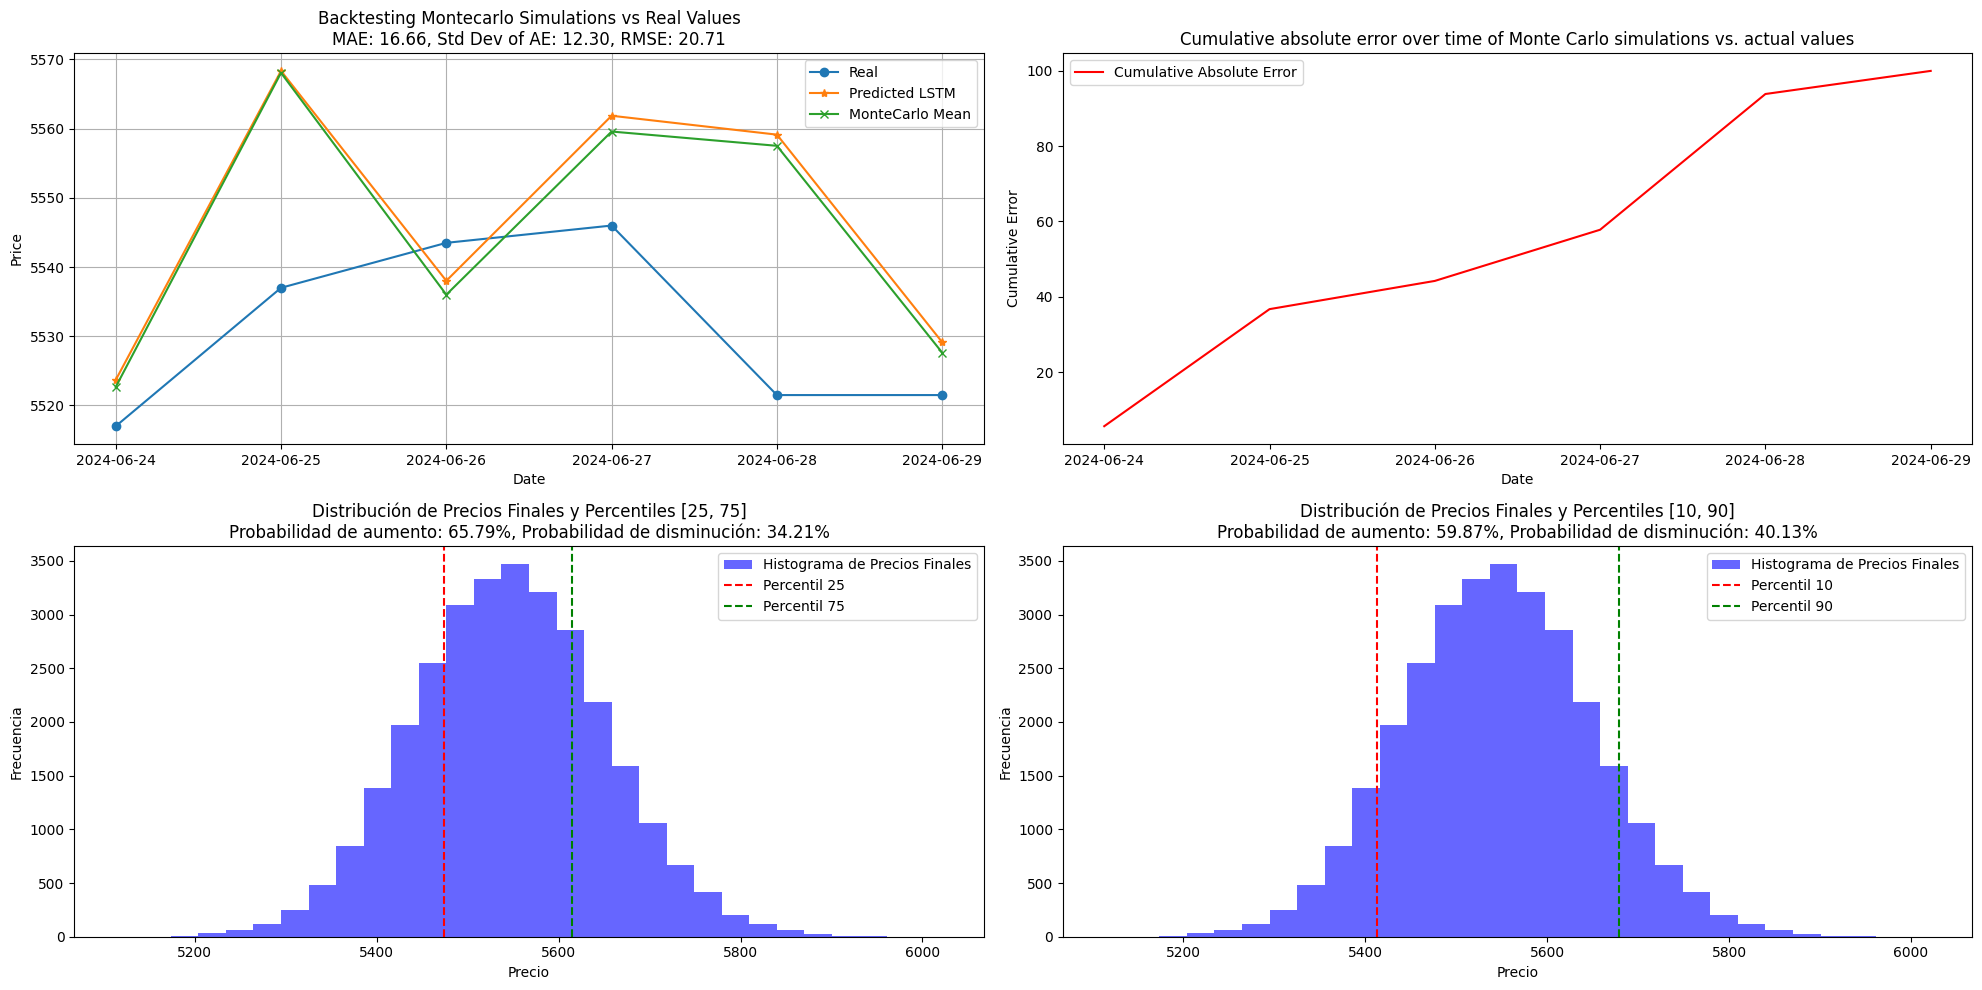

In [33]:
# Calculando errores
mae = mean_absolute_error(test_data['Actual'], test_data['MeanMC'])
mse = np.sqrt(mean_squared_error(test_data['Actual'], test_data['MeanMC']))

# Calculando la desviación estándar de los errores absolutos
errors = np.abs(test_data['Actual'] - test_data['MeanMC'])
std_dev = np.std(errors)

# Configuración de tres gráficos lado a lado
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

# Visualización de resultados en el primer gráfico
ax1.plot(test_data.index, test_data['Actual'], label='Real', marker='o')
ax1.plot(test_data.index, test_data['Predicted'], label='Predicted LSTM', marker='*')
ax1.plot(test_data.index, test_data['MeanMC'], label='MonteCarlo Mean', marker='x')
ax1.legend()
ax1.set_title('Backtesting Montecarlo Simulations vs Real Values\n' +
              f"MAE: {mae:.2f}, Std Dev of AE: {std_dev:.2f}, RMSE: {mse:.2f}")
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.grid(True)

# Visualización de resultados en el segundo gráfico
#cumulative_absolute_error = np.cumsum(np.abs(test_data['Actual'] - test_data['Predicted']))
cumulative_absolute_error = np.cumsum(np.abs(test_data['Actual'] - test_data['MeanMC']))
ax2.plot(test_data.index, cumulative_absolute_error, label='Cumulative Absolute Error', color='red')
ax2.set_title('Cumulative absolute error over time of Monte Carlo simulations vs. actual values')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Error')
ax2.legend()

# Cálculo y visualización de percentiles [25, 75] en el tercer gráfico
prices = np.concatenate(test_data['MonteCarloResults'].values)
final_prices = prices
lower_bound, upper_bound = np.percentile(final_prices, [25, 75])
filtered_prices = final_prices[(final_prices >= lower_bound) & (final_prices <= upper_bound)]
prob_increase_filtered = np.mean(filtered_prices > test_data['Predicted'].iloc[0])
prob_decrease_filtered = np.mean(filtered_prices < test_data['Predicted'].iloc[0])

ax3.hist(final_prices, bins=30, alpha=0.6, color='blue', label='Histograma de Precios Finales')
ax3.axvline(x=lower_bound, color='red', linestyle='dashed', linewidth=1.5, label='Percentil 25')
ax3.axvline(x=upper_bound, color='green', linestyle='dashed', linewidth=1.5, label='Percentil 75')
ax3.set_title('Distribución de Precios Finales y Percentiles [25, 75]\n' +
              f"Probabilidad de aumento: {prob_increase_filtered * 100:.2f}%, " +
              f"Probabilidad de disminución: {prob_decrease_filtered * 100:.2f}%")
ax3.set_xlabel('Precio')
ax3.set_ylabel('Frecuencia')
ax3.legend()

# Cálculo y visualización de percentiles [10, 90] en el cuarto gráfico
lower_bound_wide, upper_bound_wide = np.percentile(final_prices, [10, 90])
filtered_prices_wide = final_prices[(final_prices >= lower_bound_wide) & (final_prices <= upper_bound_wide)]
prob_increase_wide = np.mean(filtered_prices_wide > test_data['Predicted'].iloc[0])
prob_decrease_wide = np.mean(filtered_prices_wide < test_data['Predicted'].iloc[0])

ax4.hist(final_prices, bins=30, alpha=0.6, color='blue', label='Histograma de Precios Finales')
ax4.axvline(x=lower_bound_wide, color='red', linestyle='dashed', linewidth=1.5, label='Percentil 10')
ax4.axvline(x=upper_bound_wide, color='green', linestyle='dashed', linewidth=1.5, label='Percentil 90')
ax4.set_title('Distribución de Precios Finales y Percentiles [10, 90]\n' +
              f"Probabilidad de aumento: {prob_increase_wide * 100:.2f}%, " +
              f"Probabilidad de disminución: {prob_decrease_wide * 100:.2f}%")
ax4.set_xlabel('Precio')
ax4.set_ylabel('Frecuencia')
ax4.legend()

# Mostrar todos los gráficos
plt.tight_layout()
plt.show()